# NLTK + Scikit-Learn Integration

## Imports and Setup

In [1]:
# Importing libraries
import pickle
import pandas as pd
import numpy as np
import re
import nltk
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.metrics import confusionmatrix  # try using this later maybe and not just the accuracy score
from nltk.sentiment.vader import SentimentIntensityAnalyzer  # to get the sentiment score for the reviews
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC

# My own functions
from NLP_Functions import find_features, make_matrix, clean_up, tokenize, lemmatize, remove_stopwords

In [2]:
# Importing the 5k processed comments sample DF
df = pd.read_json('Datasets/comments_5ksample.json')
df

,Title,Platform,Userscore,Comment,Username,Comments_Processed,Target
0,Super Smash Bros. for Wii U,WiiU,9,"This game is amazing, improves in every aspect...",Zin_49,"[game, amaze, improves, every, aspect, previou...",Pos
1,Zero Escape: Zero Time Dilemma,3DS,8,A bunch of bootleg robotic versions of the mai...,Techbane,"[bunch, bootleg, robotic, version, main, chara...",Pos
2,Metro: Last Light,PC,6,I liked the original this is some innovation b...,gstiker5,"[like, original, innovation, silent, main, cha...",Pos
3,PlanetSide 2,PC,5,Planetside 2 has battles of epic scale and de...,NasseSeta,"[planetside, battle, epic, scale, decent, gfx,...",Pos
4,Diablo III,PC,1,Game looks good and overall i like the graphic...,JamesLFranco,"[game, look, good, overall, like, graphic, gam...",Neg
...,...,...,...,...,...,...,...
4995,Tom Clancy's Ghost Recon Advanced Warfighter,Xbox360,5,Definitely a good title for great graphics bu...,CiaranG.,"[definitely, good, title, great, graphic, game...",Pos
4996,The Sims,PlayStation2,10,This game is tight.,JonathanO.,"[game, tight]",Pos
4997,The Legend of Zelda: Four Swords Adventures,GameCube,10,I think this games very fun and chalenging fo...,OmarD.,"[think, game, fun, chalenging, single, player,...",Pos
4998,Half-Life,PC,10,"Half-Life has a great storyline, it was almos...",JaimyP,"[half, life, great, storyline, almost, movie, ...",Pos


In [ ]:
# Testing opening the pickled naive bayes
## not using this for now
#classifier_f = open('naivebayes.pickle', 'rb')
#classifier_og = pickle.load(classifier_f)
#classifier_f.close()

#classifier_og  # this one is the trained algo with the whole comments df

## Creating the 'Target' column

para ter uma ideia do score exato posso fazer o sentiment analysis às reviews e criar uma coluna com esses valores
e depois pegar na label do classifier + o sentiment e tentar usar isso como X de um modelo de regressão e ver se ele consegue fazer algum tipo de previsão

In [3]:
# Original Labels I created previously
## Think it was 5-10 pos
## 0-4 neg
print(df['Target'].value_counts())  # 80.7% accuracy

# Changing labels to see how accuracy responds
## 9-10 positive
## 6-8 neutral
## 5 and below negative
df['Target_2'] = np.where((df['Userscore'] <= 5), 'Negative', 'Positive')
df['Target_2'] = np.where(((df['Userscore'] >= 6) & (df['Userscore'] <= 8)), 'Neutral', df['Target_2'])

df['Target_2'].value_counts()  # this made my accuracy drop to 57%!!!

Pos    4131
Neg     869
Name: Target, dtype: int64


Positive    2923
Negative    1051
Neutral     1026
Name: Target_2, dtype: int64

In [4]:
# Trying another label change to see how accuracy responds
## 9-10 positive
## 8 and below negative
df['Target_3'] = np.where((df['Userscore'] <= 8), 'Negative', 'Positive')

df['Target_3'].value_counts()  # 63.9% accuracy

Positive    2923
Negative    2077
Name: Target_3, dtype: int64

In [5]:
# 7-10 positive
# 6 and below negative
df['Target_4'] = np.where((df['Userscore'] >= 7), 'Positive', 'Negative')  # haven't tested this one yet

df['Target_4'].value_counts()

Positive    3729
Negative    1271
Name: Target_4, dtype: int64

In [6]:
# NPS Scale - https://en.wikipedia.org/wiki/Net_Promoter
#9-10 = positive
#7-8 = neutral
#0-6 = negative
df['Target_NPS'] = np.where((df['Userscore'] <= 6), 'Negative', 'Positive')
df['Target_NPS'] = np.where(((df['Userscore'] >= 7) & (df['Userscore'] <= 8)), 'Neutral', df['Target_NPS'])

df['Target_NPS'].value_counts()  # 58.9% accuracy

Positive    2923
Negative    1271
Neutral      806
Name: Target_NPS, dtype: int64

In [7]:
df.head()

,Title,Platform,Userscore,Comment,Username,Comments_Processed,Target,Target_2,Target_3,Target_4,Target_NPS
0,Super Smash Bros. for Wii U,WiiU,9,"This game is amazing, improves in every aspect...",Zin_49,"[game, amaze, improves, every, aspect, previou...",Pos,Positive,Positive,Positive,Positive
1,Zero Escape: Zero Time Dilemma,3DS,8,A bunch of bootleg robotic versions of the mai...,Techbane,"[bunch, bootleg, robotic, version, main, chara...",Pos,Neutral,Negative,Positive,Neutral
2,Metro: Last Light,PC,6,I liked the original this is some innovation b...,gstiker5,"[like, original, innovation, silent, main, cha...",Pos,Neutral,Negative,Negative,Negative
3,PlanetSide 2,PC,5,Planetside 2 has battles of epic scale and de...,NasseSeta,"[planetside, battle, epic, scale, decent, gfx,...",Pos,Negative,Negative,Negative,Negative
4,Diablo III,PC,1,Game looks good and overall i like the graphic...,JamesLFranco,"[game, look, good, overall, like, graphic, gam...",Neg,Negative,Negative,Negative,Negative


## Adding Sentiment Score to the DF

In [9]:
# Adding all the sentiment scores to a single column
df['Sentiment_Score'] = df['Comment'].apply(SentimentIntensityAnalyzer().polarity_scores)
##df['Sentiment_Score'][0]['compound']

# Breaking down the sentiment score into a column for each of these 3 types
df['Negative_Sentiment'] = df['Sentiment_Score'].apply(lambda x: x['neg'])
df['Positive_Sentiment'] = df['Sentiment_Score'].apply(lambda x: x['pos'])
df['Compound_Sentiment'] = df['Sentiment_Score'].apply(lambda x: x['compound'])

In [10]:
# Creating a column with the comment length
## thought there could be some correlation going on here
df['Comment_Length'] = df['Comment'].apply(len)

In [11]:
# Taking a look at how the DF looks like now
df.head()

,Title,Platform,Userscore,Comment,Username,Comments_Processed,Target,Target_2,Target_3,Target_4,Target_NPS,Sentiment_Score,Negative_Sentiment,Positive_Sentiment,Compound_Sentiment,Comment_Length
0,Super Smash Bros. for Wii U,WiiU,9,"This game is amazing, improves in every aspect...",Zin_49,"[game, amaze, improves, every, aspect, previou...",Pos,Positive,Positive,Positive,Positive,"{'neg': 0.099, 'neu': 0.608, 'pos': 0.293, 'co...",0.099,0.293,0.9948,1040
1,Zero Escape: Zero Time Dilemma,3DS,8,A bunch of bootleg robotic versions of the mai...,Techbane,"[bunch, bootleg, robotic, version, main, chara...",Pos,Neutral,Negative,Positive,Neutral,"{'neg': 0.041, 'neu': 0.902, 'pos': 0.057, 'co...",0.041,0.057,0.7383,1469
2,Metro: Last Light,PC,6,I liked the original this is some innovation b...,gstiker5,"[like, original, innovation, silent, main, cha...",Pos,Neutral,Negative,Negative,Negative,"{'neg': 0.111, 'neu': 0.738, 'pos': 0.152, 'co...",0.111,0.152,-0.1405,179
3,PlanetSide 2,PC,5,Planetside 2 has battles of epic scale and de...,NasseSeta,"[planetside, battle, epic, scale, decent, gfx,...",Pos,Negative,Negative,Negative,Negative,"{'neg': 0.079, 'neu': 0.868, 'pos': 0.054, 'co...",0.079,0.054,-0.1454,337
4,Diablo III,PC,1,Game looks good and overall i like the graphic...,JamesLFranco,"[game, look, good, overall, like, graphic, gam...",Neg,Negative,Negative,Negative,Negative,"{'neg': 0.138, 'neu': 0.741, 'pos': 0.12, 'com...",0.138,0.120,-0.2886,309


In [12]:
# Userscore correlation with the other new columns
display(df.corr()[['Userscore']][1:])

# Whole DF correlation
df.corr()

,Userscore
Negative_Sentiment,-0.423701
Positive_Sentiment,0.379210
Compound_Sentiment,0.479216
Comment_Length,-0.074497


,Userscore,Negative_Sentiment,Positive_Sentiment,Compound_Sentiment,Comment_Length
Userscore,1.000000,-0.423701,0.379210,0.479216,-0.074497
Negative_Sentiment,-0.423701,1.000000,-0.369241,-0.646180,0.079057
Positive_Sentiment,0.379210,-0.369241,1.000000,0.548399,-0.245252
Compound_Sentiment,0.479216,-0.646180,0.548399,1.000000,0.036388
Comment_Length,-0.074497,0.079057,-0.245252,0.036388,1.000000


## Initializing the Original NLTK NB Model

In [14]:
%%time
# test the whole confusion matrix instead of just accuracy to see if it all matches nicely

# INITIALIZING EVERYTHING TO BEGIN TESTING WITH DIFFERENT MODELS

# Creating the bag of words
bow = [word for lst in df['Comments_Processed'] for word in lst]
fdist = FreqDist(bow)

# Getting just the 5k most common words
most_common = fdist.most_common(5000)

# Building the features and making the matrix
matrix_1 = make_matrix(df['Comment'], df['Target'], most_common)

# Defining the size to use for the training and testing
size_1 = int(len(matrix_1) * 0.20)

# Training with 80% of the data and testing against the remaining 20%
training_set_1 = matrix_1[size_1:]
testing_set_1 = matrix_1[:size_1]

# Initializing and training the model
classifier_1 = nltk.NaiveBayesClassifier.train(training_set_1)

# Showing the top 15 most informative features
classifier_1.show_most_informative_features(15)

# Printing the model's accuracy
print(f'\nOriginal NLTK NB accuracy (Target): {round(nltk.classify.accuracy(classifier_1, testing_set_1) * 100, 2)}%\n')

Most Informative Features
                   greed = True              Neg : Pos    =     29.4 : 1.0
                  refund = True              Neg : Pos    =     27.5 : 1.0
                lifeless = True              Neg : Pos    =     26.9 : 1.0
                   false = True              Neg : Pos    =     23.7 : 1.0
                  delete = True              Neg : Pos    =     20.5 : 1.0
                defender = True              Neg : Pos    =     17.4 : 1.0
             maintenance = True              Neg : Pos    =     17.4 : 1.0
                 garbage = True              Neg : Pos    =     16.8 : 1.0
                 fanbase = True              Neg : Pos    =     16.1 : 1.0
                  greedy = True              Neg : Pos    =     16.1 : 1.0
                    glen = True              Neg : Pos    =     14.2 : 1.0
                customer = True              Neg : Pos    =     13.4 : 1.0
                    turd = True              Neg : Pos    =     12.3 : 1.0

### Testing with Target_2 (Positive, Negative, Neutral)

In [15]:
%%time
# Building the features and making the matrix
matrix_2 = make_matrix(df['Comment'], df['Target_2'], most_common)

# Defining the size to use for the training and testing
size_2 = int(len(matrix_2) * 0.20)

# Training with 80% of the data and testing against the remaining 20%
training_set_2 = matrix_2[size_2:]
testing_set_2 = matrix_2[:size_2]

# Initializing and training the model
classifier_2 = nltk.NaiveBayesClassifier.train(training_set_2)

# Showing the top 15 most informative features
classifier_2.show_most_informative_features(15)

# Printing the model's accuracy
print(f'\nOriginal NLTK NB accuracy (Target_2): {round(nltk.classify.accuracy(classifier_2, testing_set_2) * 100, 2)}%\n')

Most Informative Features
                   greed = True           Negati : Positi =     28.6 : 1.0
                  refund = True           Negati : Positi =     26.8 : 1.0
              activision = True           Negati : Positi =     22.7 : 1.0
                 garbage = True           Negati : Positi =     21.8 : 1.0
                  unable = True           Neutra : Positi =     21.7 : 1.0
                customer = True           Negati : Positi =     18.3 : 1.0
                   bland = True           Negati : Positi =     16.3 : 1.0
                 fanbase = True           Negati : Positi =     15.7 : 1.0
                  greedy = True           Negati : Positi =     15.7 : 1.0
                     drm = True           Negati : Positi =     15.0 : 1.0
                  poorly = True           Negati : Positi =     14.9 : 1.0
                   hyped = True           Negati : Positi =     14.5 : 1.0
                  finger = True           Neutra : Positi =     14.1 : 1.0

### Testing with Target_3 (Positive, Negative --> pretty well-balanced now)

In [16]:
%%time
# Building the features and making the matrix
matrix_3 = make_matrix(df['Comment'], df['Target_3'], most_common)

# Defining the size to use for the training and testing
size_3 = int(len(matrix_3) * 0.20)

# Training with 80% of the data and testing against the remaining 20%
training_set_3 = matrix_3[size_3:]
testing_set_3 = matrix_3[:size_3]

# Initializing and training the model
classifier_3 = nltk.NaiveBayesClassifier.train(training_set_3)

# Showing the top 15 most informative features
classifier_3.show_most_informative_features(15)

# Printing the model's accuracy
print(f'\nOriginal NLTK NB accuracy (Target_3): {round(nltk.classify.accuracy(classifier_3, testing_set_3) * 100, 2)}%\n')

Most Informative Features
                   greed = True           Negati : Positi =     15.4 : 1.0
              activision = True           Negati : Positi =     14.8 : 1.0
                  unable = True           Negati : Positi =     14.5 : 1.0
                  refund = True           Negati : Positi =     14.5 : 1.0
                   bland = True           Negati : Positi =     14.1 : 1.0
                 garbage = True           Negati : Positi =     12.2 : 1.0
                  finger = True           Negati : Positi =     11.7 : 1.0
              motivation = True           Negati : Positi =     11.7 : 1.0
               overrated = True           Negati : Positi =     11.7 : 1.0
                overrate = True           Negati : Positi =     11.7 : 1.0
                   hyped = True           Negati : Positi =     11.7 : 1.0
                 alright = True           Negati : Positi =     11.4 : 1.0
                  poorly = True           Negati : Positi =     11.3 : 1.0

### Testing with Target_NPS

In [18]:
%%time
# Building the features and making the matrix
matrix_NPS = make_matrix(df['Comment'], df['Target_NPS'], most_common)

# Defining the size to use for the training and testing
size_NPS = int(len(matrix_NPS) * 0.20)

# Training with 80% of the data and testing against the remaining 20%
training_set_NPS = matrix_NPS[size_NPS:]
testing_set_NPS = matrix_NPS[:size_NPS]

# Initializing and training the model
classifier_NPS = nltk.NaiveBayesClassifier.train(training_set_NPS)

# Showing the top 15 most informative features
classifier_NPS.show_most_informative_features(15)

# Printing the model's accuracy
print(f'\nOriginal NLTK NB accuracy (Target_NPS): {round(nltk.classify.accuracy(classifier_NPS, testing_set_NPS) * 100, 2)}%\n')

Most Informative Features
                   greed = True           Negati : Positi =     23.7 : 1.0
                  refund = True           Negati : Positi =     22.1 : 1.0
              activision = True           Negati : Positi =     21.5 : 1.0
                 garbage = True           Negati : Positi =     18.7 : 1.0
                   bland = True           Negati : Positi =     18.6 : 1.0
               painfully = True           Negati : Positi =     17.6 : 1.0
                  unable = True           Neutra : Positi =     15.6 : 1.0
              motivation = True           Neutra : Positi =     15.6 : 1.0
                   hyped = True           Negati : Positi =     15.5 : 1.0
                   fails = True           Negati : Positi =     15.1 : 1.0
                customer = True           Negati : Positi =     15.1 : 1.0
                  poorly = True           Negati : Positi =     14.8 : 1.0
                 alright = True           Negati : Positi =     14.7 : 1.0

## Predicting the label of the 'testing_set'

In [19]:
# pode ser interessante ter uma coluna com o sentiment score e depois fazer um scale p estar de 0-10 e um t-test no
# final para comparar a media deles com a original
# se houver correspondencia posso usar o input p fazer uma regressão?

# List comprehension to make the predictions for the whole testing_set
pred_list_1 = [classifier_1.classify(testing_set_1[i][0]) for i in range(len(testing_set_1))]

In [20]:
# This was with the original Target label column
print(pred_list_1.count('Pos'))  # 783
print(pred_list_1.count('Neg'))  # 217

783
217


In [21]:
df[['Comment', 'Target']].values#[0]

array([["This game is amazing, improves in every aspect from the previous Smash Bros, and the fighting is as perfect as ever. The new modes are fantastically fun and 8 Smash Brawl is pure chaos but hilarious with friends. Everything new that was introduced is marvelous.A few downsides though is how there is no Story Mode like the one in Brawl (Subspace Emissary) I really enjoyed it and wasThis game is amazing, improves in every aspect from the previous Smash Bros, and the fighting is as perfect as ever. The new modes are fantastically fun and 8 Smash Brawl is pure chaos but hilarious with friends. Everything new that was introduced is marvelous.A few downsides though is how there is no Story Mode like the one in Brawl (Subspace Emissary) I really enjoyed it and was hoping for a new one. Also Smash Tour can be confusing at times and be a little tricky, also the amount of clones (Dr. Mario and Dark Pit?) is just isn't a good choice.But with that in mind Smash is one of the greatest games

In [22]:
# Just testing something
sorted(most_common, key = lambda x: x[0])[1100:]

[('deliver', 124),
 ('delivers', 29),
 ('delivery', 10),
 ('deluxe', 7),
 ('delve', 10),
 ('dem', 7),
 ('demand', 38),
 ('demo', 63),
 ('demon', 72),
 ('demonic', 9),
 ('deny', 20),
 ('department', 26),
 ('depend', 65),
 ('dependent', 7),
 ('depois', 6),
 ('depress', 15),
 ('depth', 188),
 ('der', 19),
 ('des', 12),
 ('descent', 11),
 ('describe', 77),
 ('description', 15),
 ('desde', 15),
 ('desert', 26),
 ('deserve', 204),
 ('design', 593),
 ('designer', 22),
 ('desire', 42),
 ('desmond', 11),
 ('desperate', 8),
 ('desperately', 6),
 ('despite', 164),
 ('destination', 9),
 ('destiny', 40),
 ('destroy', 111),
 ('destructible', 11),
 ('destruction', 28),
 ('detail', 245),
 ('detailed', 63),
 ('detalles', 6),
 ('detect', 7),
 ('detection', 18),
 ('detective', 7),
 ('deter', 8),
 ('determine', 13),
 ('detract', 11),
 ('deus', 49),
 ('dev', 18),
 ('develop', 103),
 ('developed', 23),
 ('developer', 291),
 ('development', 147),
 ('device', 11),
 ('devil', 32),
 ('devote', 9),
 ('devs', 39)

In [23]:
a = find_features('This game sucks so much. I hate it a lot. This is complete garbage. Worst game ever.', most_common)

In [24]:
classifier_NPS.classify(a)  # bad sign lol

'Positive'

In [28]:
# It seems I need a featureset (a dict) to be able to predict something

'''
Since the .classify is taking the testing_set as an arg, I looked into it and the testing_set is a dict with the
keys being the words (already processed, I think) and the value is true or false - if they are or not in the
5k most_common list??

With that in mind I decided to create this func that would clean up a string that it receives to be somewhat
closer to the type of input the .classify receives (aka the testing_set), just in case I wanted to do some further testing.'''
def text_cleaner(text):
    return remove_stopwords(lemmatize(tokenize(clean_up(text))))

text_cleaner('I love this game!! 63@5@653')

#classifier_1.classify()
#testing_set_1[0][0]
#matrix_1[0][0]

['love', 'game']

In [29]:
# Predictions with the 'Target_2' column
pred_list_2 = [classifier_2.classify(testing_set_2[i][0]) for i in range(len(testing_set_2))]

In [30]:
pred_list_2
print(pred_list_2.count('Positive'))  # 607
print(pred_list_2.count('Negative'))  # 103
print(pred_list_2.count('Neutral'))  # 290

607
103
290


In [31]:
# Predictions with the 'Target_3' column
pred_list_3 = [classifier_3.classify(testing_set_3[i][0]) for i in range(len(testing_set_3))]

In [32]:
pred_list_3
print(pred_list_3.count('Positive'))  # 636
print(pred_list_3.count('Negative'))  # 364

636
364


### TextBlob Comparisson

In [33]:
# NLTK
testimonial = 'This game sucks so much. I hate it a lot. This is complete garbage.'
analyzer = SentimentIntensityAnalyzer()
analyzer.polarity_scores(testimonial)

{'neg': 0.393, 'neu': 0.607, 'pos': 0.0, 'compound': -0.7564}

In [35]:
# TextBlob
from textblob import TextBlob
testimonial = TextBlob('This game sucks so much. I hate it a lot. This is complete garbage.')
print(testimonial.sentiment)
#print(testimonial.sentiment.polarity)
df['TextBlob_Polarity'] = df['Comment'].apply(lambda x: TextBlob(x).sentiment.polarity)

Sentiment(polarity=-0.35, subjectivity=0.5)


In [36]:
df.head()

,Title,Platform,Userscore,Comment,Username,Comments_Processed,Target,Target_2,Target_3,Target_4,Target_NPS,Sentiment_Score,Negative_Sentiment,Positive_Sentiment,Compound_Sentiment,Comment_Length,TextBlob_Polarity
0,Super Smash Bros. for Wii U,WiiU,9,"This game is amazing, improves in every aspect...",Zin_49,"[game, amaze, improves, every, aspect, previou...",Pos,Positive,Positive,Positive,Positive,"{'neg': 0.099, 'neu': 0.608, 'pos': 0.293, 'co...",0.099,0.293,0.9948,1040,0.208261
1,Zero Escape: Zero Time Dilemma,3DS,8,A bunch of bootleg robotic versions of the mai...,Techbane,"[bunch, bootleg, robotic, version, main, chara...",Pos,Neutral,Negative,Positive,Neutral,"{'neg': 0.041, 'neu': 0.902, 'pos': 0.057, 'co...",0.041,0.057,0.7383,1469,0.100090
2,Metro: Last Light,PC,6,I liked the original this is some innovation b...,gstiker5,"[like, original, innovation, silent, main, cha...",Pos,Neutral,Negative,Negative,Negative,"{'neg': 0.111, 'neu': 0.738, 'pos': 0.152, 'co...",0.111,0.152,-0.1405,179,0.228333
3,PlanetSide 2,PC,5,Planetside 2 has battles of epic scale and de...,NasseSeta,"[planetside, battle, epic, scale, decent, gfx,...",Pos,Negative,Negative,Negative,Negative,"{'neg': 0.079, 'neu': 0.868, 'pos': 0.054, 'co...",0.079,0.054,-0.1454,337,-0.054167
4,Diablo III,PC,1,Game looks good and overall i like the graphic...,JamesLFranco,"[game, look, good, overall, like, graphic, gam...",Neg,Negative,Negative,Negative,Negative,"{'neg': 0.138, 'neu': 0.741, 'pos': 0.12, 'com...",0.138,0.120,-0.2886,309,-0.087033


In [37]:
df.corr()

,Userscore,Negative_Sentiment,Positive_Sentiment,Compound_Sentiment,Comment_Length,TextBlob_Polarity
Userscore,1.000000,-0.423701,0.379210,0.479216,-0.074497,0.458278
Negative_Sentiment,-0.423701,1.000000,-0.369241,-0.646180,0.079057,-0.465992
Positive_Sentiment,0.379210,-0.369241,1.000000,0.548399,-0.245252,0.584022
Compound_Sentiment,0.479216,-0.646180,0.548399,1.000000,0.036388,0.500232
Comment_Length,-0.074497,0.079057,-0.245252,0.036388,1.000000,-0.107799
TextBlob_Polarity,0.458278,-0.465992,0.584022,0.500232,-0.107799,1.000000


In [49]:
a = find_features('This game sucks so much. I hate it a lot. This is complete garbage', most_common)
print(classifier_NPS.classify(a))  # this new NPS target label still can't identify this as negative...

# interesting...
#print(classifier_NPS.classify({'worst': True}))  # neg
#print(classifier_NPS.classify({'terrible': True}))  # terribl - pos ; terrible - neg

Positive


In [45]:
a

{'game': True,
 'play': False,
 'like': False,
 'get': False,
 'good': False,
 'make': False,
 'one': False,
 'story': False,
 'time': False,
 'great': False,
 'really': False,
 'best': False,
 'well': False,
 'character': False,
 'graphic': False,
 'even': False,
 'go': False,
 'much': True,
 'new': False,
 'give': False,
 'fun': False,
 'first': False,
 'gameplay': False,
 'feel': False,
 'say': False,
 'thing': False,
 'would': False,
 'player': False,
 'ever': False,
 'also': False,
 'way': False,
 'still': False,
 'look': False,
 'think': False,
 'take': False,
 'bad': False,
 'people': False,
 'world': False,
 'lot': True,
 'want': False,
 'see': False,
 'many': False,
 'hour': False,
 'love': False,
 'level': False,
 'find': False,
 'end': False,
 'use': False,
 'every': False,
 'year': False,
 'buy': False,
 'review': False,
 'come': False,
 'experience': False,
 'could': False,
 'combat': False,
 'multiplayer': False,
 'know': False,
 'system': False,
 'series': False,
 'try':

In [46]:
b = find_features('Textblob is amazingly simple to use. What great fun!', most_common)
classifier_NPS.classify(b)

'Positive'

## Under-sampling the Data

In [50]:
# Count of pos and neg
pos_count, neg_count = df['Target'].value_counts()

# Dividing by either pos or neg
df_class_pos = df[df['Target'] == 'Pos']
df_class_neg = df[df['Target'] == 'Neg']

Random under-sampling:
Neg    869
Pos    869
Name: Target, dtype: int64


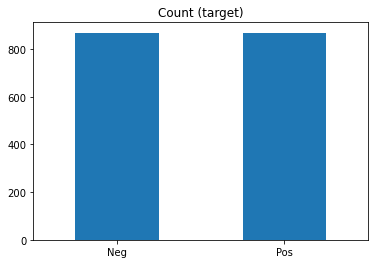

In [54]:
# New DF with a random sample (of the same length as the neg_count) of the old DF with just 'pos' (inital Target column)
df_pos_under = df_class_pos.sample(neg_count)

# New DF that joins the pos and neg, now of the same length
df_under_1 = pd.concat([df_pos_under, df_class_neg], axis = 0)

# Resetting the index cuz I want to
df_under_1.reset_index(drop = True, inplace = True)

print('Random under-sampling:')
print(df_under_1['Target'].value_counts())

df_under_1['Target'].value_counts().plot(kind = 'bar', title = 'Count (target)', rot = 0);

In [56]:
df_under_1.head()#['Target'].value_counts()

,Title,Platform,Userscore,Comment,Username,Comments_Processed,Target,Target_2,Target_3,Target_4,Target_NPS,Sentiment_Score,Negative_Sentiment,Positive_Sentiment,Compound_Sentiment,Comment_Length,TextBlob_Polarity
0,Hellblade: Senua's Sacrifice,XboxOne,9,In progress: Well so far the game is very well...,TrentRey,"[progress, well, far, game, well, crate, story...",Pos,Positive,Positive,Positive,Positive,"{'neg': 0.043, 'neu': 0.671, 'pos': 0.286, 'co...",0.043,0.286,0.9936,892,0.178194
1,Kingdoms of Amalur: Reckoning,PC,9,"Okay, so the environment and character graphic...",wcparry,"[okay, environment, character, graphic, includ...",Pos,Positive,Positive,Positive,Positive,"{'neg': 0.077, 'neu': 0.799, 'pos': 0.124, 'co...",0.077,0.124,0.9817,3014,0.096512
2,Need for Speed: Most Wanted - A Criterion Game,Xbox360,6,The only need for speed that i loved is most ...,Pepefromage,"[need, speed, love, want, original, one, dna, ...",Pos,Neutral,Negative,Negative,Negative,"{'neg': 0.071, 'neu': 0.653, 'pos': 0.276, 'co...",0.071,0.276,0.9973,1399,0.187914
3,Mass Effect 3,PC,10,"Great game, loved every minute of it, except f...",charrudeboy,"[great, game, love, every, minute, except, end...",Pos,Positive,Positive,Positive,Positive,"{'neg': 0.099, 'neu': 0.699, 'pos': 0.202, 'co...",0.099,0.202,0.3716,159,0.283333
4,South Park: The Stick of Truth,PC,8,"Simply put, the best South Park game to ever h...",merc_god,"[simply, put, best, south, park, game, ever, h...",Pos,Neutral,Negative,Positive,Neutral,"{'neg': 0.109, 'neu': 0.641, 'pos': 0.25, 'com...",0.109,0.250,0.9857,1012,0.191920


### TESTING AGAIN WITH UNDERSAMPLED DATA

In [57]:
%%time
# Building the features and making the matrix
matrix_under_samp = make_matrix(df_under_1['Comment'], df_under_1['Target'], most_common)

# Defining the size to use for the training and testing
size_under_samp = int(len(matrix_under_samp) * 0.20)

# Training with 80% of the data and testing against the remaining 20%
training_set_under_samp = matrix_under_samp[size_under_samp:]
testing_set_under_samp = matrix_under_samp[:size_under_samp]

# Initializing and training the model
classifier_under_samp = nltk.NaiveBayesClassifier.train(training_set_under_samp)

# Showing the top 15 most informative features
classifier_under_samp.show_most_informative_features(15)

# Printing the model's accuracy
print(f'\nOriginal NLTK NB accuracy (Target) undersampled: {round(nltk.classify.accuracy(classifier_under_samp, testing_set_under_samp) * 100, 2)}%\n')
# good accuracy - 80.4%

Most Informative Features
               immersive = True              Pos : Neg    =     13.9 : 1.0
                   worst = True              Neg : Pos    =     13.7 : 1.0
             masterpiece = True              Pos : Neg    =     13.0 : 1.0
                   awful = True              Neg : Pos    =     11.7 : 1.0
              activision = True              Neg : Pos    =     10.2 : 1.0
                customer = True              Neg : Pos    =      9.8 : 1.0
              collection = True              Pos : Neg    =      9.4 : 1.0
                  varied = True              Pos : Neg    =      9.4 : 1.0
              unplayable = True              Neg : Pos    =      9.4 : 1.0
                     bag = True              Neg : Pos    =      9.0 : 1.0
                blizzard = True              Neg : Pos    =      8.8 : 1.0
                   greed = True              Neg : Pos    =      8.6 : 1.0
                   zelda = True              Pos : Neg    =      8.3 : 1.0

In [59]:
bad_sentence = find_features('This game sucks so much. I hate it a lot. This is complete garbage', most_common)
print(classifier_under_samp.classify(bad_sentence))
# Ok, it still said it is positive, so... I'm done. Don't know what else to do lol

Pos


## Testing with other models in Scikit-learn

Discarded Bernoulli NB, default accuracy was only 59.2%.

NuSVC didn't work.

### Multinomial NB

In [60]:
%%time
# UNDERSAMPLING TEST
MNB_classifier_under_samp = SklearnClassifier(MultinomialNB())
MNB_classifier_under_samp.train(training_set_under_samp)

print(f'\nMultinomial NB accuracy (Target) undersampled: {round(nltk.classify.accuracy(MNB_classifier_under_samp, testing_set_under_samp) * 100, 2)}%\n')
# Got a worse score this time than the NLTK one but I think this is the best result so far, even with undersampled data
# Makes me feel like it's the most true one, and it managed to classify that bad sentence correctly


Multinomial NB accuracy (Target) undersampled: 77.52%

CPU times: user 4.44 s, sys: 234 ms, total: 4.68 s
Wall time: 4.73 s


In [61]:
print(MNB_classifier_under_samp.classify(bad_sentence))
# OMGGGGG this one at least finally said this god damn sentence is negative!!!

Neg


In [65]:
%%time
# TESTING WITH TARGET_NPS
MNB_classifier_NPS = SklearnClassifier(MultinomialNB(alpha = 2))
MNB_classifier_NPS.train(training_set_NPS)

print(f'\nMultinomial NB accuracy (Target_NPS): {round(nltk.classify.accuracy(MNB_classifier_NPS, testing_set_NPS) * 100, 2)}%\n')


Multinomial NB accuracy (Target_NPS): 70.8%

CPU times: user 15.2 s, sys: 1.96 s, total: 17.2 s
Wall time: 18.3 s


In [66]:
print(MNB_classifier_NPS.classify(bad_sentence))  # negative, yesssss

Negative


In [67]:
# Predictions of the testing_set with the Target_NPS column
pred_list_MNB_NPS = [MNB_classifier_NPS.classify(testing_set_NPS[i][0]) for i in range(len(testing_set_NPS))]
print(pred_list_MNB_NPS.count('Positive'))  # 677
print(pred_list_MNB_NPS.count('Negative'))  # 228
print(pred_list_MNB_NPS.count('Neutral'))  # 95

677
228
95


#### Good result here with the Target_3 column!

In [68]:
%%time
# Testing the Multinomial NB model with Target_3 column
MNB_classifier_3 = SklearnClassifier(MultinomialNB())
MNB_classifier_3.train(training_set_3)

print(f'\nMultinomial NB accuracy (Target_3): {round(nltk.classify.accuracy(MNB_classifier_3, testing_set_3) * 100, 2)}%\n')
# Very good result! 76% and without having to undersample data, and it classified the bad sentence correctly!


Multinomial NB accuracy (Target_3): 76.1%

CPU times: user 15.2 s, sys: 1.85 s, total: 17.1 s
Wall time: 18.2 s


In [69]:
print(MNB_classifier_3.classify(bad_sentence))

Negative


In [70]:
df['Target_3'].value_counts()

Positive    2923
Negative    2077
Name: Target_3, dtype: int64

### Undersampling Target_3

In [71]:
# UNDER-SAMPLING A NEW DF FOR TARGET_3 TESTING
df_3_pos = df[df['Target_3'] == 'Positive']
df_3_neg = df[df['Target_3'] == 'Negative']

df_3_pos_under = df_3_pos.sample(2077)

df_3_under = pd.concat([df_3_pos_under, df_3_neg])

In [72]:
df_3_under['Target_3'].value_counts()  # perfectly balanced now

Negative    2077
Positive    2077
Name: Target_3, dtype: int64

#### Testing the Multinomial NB model with Target_3 UNDERSAMPLED DF

In [73]:
%%time
# Building the features and making the matrix
matrix_3_under = make_matrix(df_3_under['Comment'], df_3_under['Target_3'], most_common)

# Defining the size to use for the training and testing
size_3_under = int(len(matrix_3_under) * 0.20)

# Training with 80% of the data and testing against the remaining 20%
training_set_3_under = matrix_3_under[size_3_under:]
testing_set_3_under = matrix_3_under[:size_3_under]

# Initializing the model and training it
MNB_classifier_3_under = SklearnClassifier(MultinomialNB())
MNB_classifier_3_under.train(training_set_3_under)

print(f'\nMultinomial NB accuracy (Target_3) undersampled: {round(nltk.classify.accuracy(MNB_classifier_3_under, testing_set_3_under) * 100, 2)}%\n')
# score went from 76.1% to 77.59% - minor increase, don't know if it justifies having to lose a lot of data in the undersampling process


Multinomial NB accuracy (Target_3) undersampled: 77.59%

CPU times: user 26.2 s, sys: 849 ms, total: 27.1 s
Wall time: 27.7 s


### Logistic Regression

In [74]:
%%time
# Testing with normal Target_3
LogisticRegression_classifier_3 = SklearnClassifier(LogisticRegression(solver = 'saga'))
LogisticRegression_classifier_3.train(training_set_3)

print(f'\nLogistic Regression accuracy (Target_3): {round(nltk.classify.accuracy(LogisticRegression_classifier_3, testing_set_3) * 100, 2)}%\n')

/opt/miniconda3/envs/Data_Analytics/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "



Logistic Regression accuracy (Target_3): 77.3%

CPU times: user 28.5 s, sys: 827 ms, total: 29.4 s
Wall time: 30 s


In [75]:
%%time
# Testing with Target_3_under UNDERSAMPLED VERSION
LogisticRegression_classifier_3_under = SklearnClassifier(LogisticRegression(solver = 'saga'))
LogisticRegression_classifier_3_under.train(training_set_3_under)

print(f'\nLogistic Regression accuracy (Target_3) undersampled: {round(nltk.classify.accuracy(LogisticRegression_classifier_3_under, testing_set_3_under) * 100, 2)}%\n')
# oh well, this was unexpected. Quite a big drop from 77.3% to 62.05% with the undersampled version

/opt/miniconda3/envs/Data_Analytics/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "



Logistic Regression accuracy (Target_3) undersampled: 62.05%

CPU times: user 22.9 s, sys: 733 ms, total: 23.6 s
Wall time: 23.7 s


In [76]:
%%time
# Testing with Target_NPS
LogisticRegression_classifier_NPS = SklearnClassifier(LogisticRegression(solver = 'saga'))
LogisticRegression_classifier_NPS.train(training_set_NPS)

print(f'\nLogistic Regression accuracy (Target_NPS): {round(nltk.classify.accuracy(LogisticRegression_classifier_NPS, testing_set_NPS) * 100, 2)}%\n')

/opt/miniconda3/envs/Data_Analytics/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "



Logistic Regression accuracy (Target_NPS): 69.8%

CPU times: user 49.8 s, sys: 1.01 s, total: 50.8 s
Wall time: 51.7 s


In [77]:
print(LogisticRegression_classifier_NPS.classify(bad_sentence))

Negative


### SGD Classifier

In [78]:
%%time
SGDClassifier_classifier = SklearnClassifier(SGDClassifier())
SGDClassifier_classifier.train(training_set_NPS)

print(f'\nSGDClassifier_classifier accuracy (Target_NPS): {round(nltk.classify.accuracy(SGDClassifier_classifier, testing_set_NPS) * 100, 2)}%\n')


SGDClassifier_classifier accuracy (Target_NPS): 66.9%

CPU times: user 18.8 s, sys: 800 ms, total: 19.6 s
Wall time: 20.1 s


### SVC

In [79]:
%%time
SVC_classifier = SklearnClassifier(SVC())
SVC_classifier.train(training_set_NPS)

print(f'\nSVC_classifier accuracy (Target_NPS): {round(nltk.classify.accuracy(SVC_classifier, testing_set_NPS) * 100, 2)}%\n')

# 73% - seems like it's the best one for target_NPS! However, this is probablity horrible for large datasets
## as it will take forever to finish. They even advise using linear svc or SGD instead...


SVC_classifier accuracy (Target_NPS): 73.0%

CPU times: user 2min 40s, sys: 1.42 s, total: 2min 41s
Wall time: 2min 43s


### Linear SVC

In [80]:
%%time
LinearSVC_classifier = SklearnClassifier(LinearSVC())
LinearSVC_classifier.train(training_set_NPS)

print(f'\nLinearSVC_classifier accuracy (Target_NPS): {round(nltk.classify.accuracy(LinearSVC_classifier, testing_set_NPS) * 100, 2)}%\n')

/opt/miniconda3/envs/Data_Analytics/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



LinearSVC_classifier accuracy (Target_NPS): 65.8%

CPU times: user 1min 12s, sys: 904 ms, total: 1min 13s
Wall time: 1min 14s
